In [25]:
import pandas as pd
import numpy as np
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\New folder\final_load_weather_data.csv")
df.head()


,ds,y,forecast_load,Unnamed: 0,dt,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
0,2015-01-01 01:00:00+00:00,26118.0,25385.0,11075,2015-01-01 02:00:00,2509954,269.686000,269.686000,269.686000,1002,78,0,23,0.0,0.0,0.0,0,800
1,2015-01-01 01:00:00+00:00,26118.0,25385.0,63228,2015-01-01 02:00:00,3117735,266.186000,266.186000,266.186000,971,64,1,273,0.0,0.0,0.0,0,800
2,2015-01-01 01:00:00+00:00,26118.0,25385.0,116333,2015-01-01 02:00:00,3128026,269.251688,269.251688,269.251688,1036,97,1,224,0.0,0.0,0.0,0,800
3,2015-01-01 01:00:00+00:00,26118.0,25385.0,169280,2015-01-01 02:00:00,3128760,281.286000,281.286000,281.286000,1036,100,7,48,0.0,0.0,0.0,0,800
4,2015-01-01 01:00:00+00:00,26118.0,25385.0,221705,2015-01-01 02:00:00,6361046,274.086000,274.086000,274.086000,1039,71,3,27,0.0,0.0,0.0,0,800


In [26]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load and sort
df = df.drop(columns=['Unnamed: 0', 'dt', 'forecast_load'])
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['city_id', 'ds'])


In [27]:
def preprocess_city(df, city_id, seq_len=24):
    df_city = df[df['city_id'] == city_id].copy().dropna()
    features = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
                'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
                'clouds_all', 'weather_id']
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(df_city[features])
    y_scaled = scaler_y.fit_transform(df_city[['y']])

    def create_sequences(X, y, seq_len):
        Xs, ys = [], []
        for i in range(len(X) - seq_len):
            Xs.append(X[i:i+seq_len])
            ys.append(y[i+seq_len])
        return np.array(Xs), np.array(ys)

    X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)
    return X_seq, y_seq, scaler_X, scaler_y


In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


In [29]:
def train_lstm_model(X_seq, y_seq, input_size, epochs=20):
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.float32)

    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    model = LSTMModel(input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

    return model


In [32]:
def forecast_next(model, last_seq, scaler_y):
    with torch.no_grad():
        input_tensor = torch.tensor(last_seq[None, :, :], dtype=torch.float32)
        pred = model(input_tensor)
        pred_val = pred.item()  # Extract scalar float

        # Manual inverse transform of MinMaxScaler
        y_min = scaler_y.data_min_[0]
        y_max = scaler_y.data_max_[0]
        return pred_val * (y_max - y_min) + y_min


In [33]:
for city in df['city_id'].unique():
    print(f"\nTraining for City ID: {city}")
    X_seq, y_seq, scaler_X, scaler_y = preprocess_city(df, city)
    model = train_lstm_model(X_seq, y_seq, input_size=X_seq.shape[2])
    next_load = forecast_next(model, X_seq[-1], scaler_y)
    print(f"Forecasted next hour load for city {city}: {next_load:.2f}")



Training for City ID: 2509954
Epoch 1: Loss = 0.0052
Epoch 2: Loss = 0.0206
Epoch 3: Loss = 0.0288
Epoch 4: Loss = 0.0210
Epoch 5: Loss = 0.0146
Epoch 6: Loss = 0.0114
Epoch 7: Loss = 0.0111
Epoch 8: Loss = 0.0129
Epoch 9: Loss = 0.0151
Epoch 10: Loss = 0.0162
Epoch 11: Loss = 0.0154
Epoch 12: Loss = 0.0147
Epoch 13: Loss = 0.0145
Epoch 14: Loss = 0.0144
Epoch 15: Loss = 0.0143
Epoch 16: Loss = 0.0147
Epoch 17: Loss = 0.0152
Epoch 18: Loss = 0.0154
Epoch 19: Loss = 0.0155
Epoch 20: Loss = 0.0157
Forecasted next hour load for city 2509954: 27782.10

Training for City ID: 3117735
Epoch 1: Loss = 0.0169
Epoch 2: Loss = 0.0239
Epoch 3: Loss = 0.0302
Epoch 4: Loss = 0.0299
Epoch 5: Loss = 0.0290
Epoch 6: Loss = 0.0282
Epoch 7: Loss = 0.0277
Epoch 8: Loss = 0.0287
Epoch 9: Loss = 0.0285
Epoch 10: Loss = 0.0276
Epoch 11: Loss = 0.0274
Epoch 12: Loss = 0.0275
Epoch 13: Loss = 0.0275
Epoch 14: Loss = 0.0274
Epoch 15: Loss = 0.0271
Epoch 16: Loss = 0.0269
Epoch 17: Loss = 0.0268
Epoch 18: Loss 

In [34]:
results = []

for city in df['city_id'].unique():
    print(f"\nTraining for City ID: {city}")
    X_seq, y_seq, scaler_X, scaler_y = preprocess_city(df, city)
    model = train_lstm_model(X_seq, y_seq, input_size=X_seq.shape[2])
    next_load = forecast_next(model, X_seq[-1], scaler_y)
    print(f"Forecasted next hour load for city {city}: {next_load:.2f}")
    
    results.append({
        "city_id": city,
        "forecasted_next_hour_load": round(next_load, 2)
    })

forecast_df = pd.DataFrame(results)
print("\n📊 Final Forecasts:")
print(forecast_df)



Training for City ID: 2509954
Epoch 1: Loss = 0.0070
Epoch 2: Loss = 0.0250
Epoch 3: Loss = 0.0233
Epoch 4: Loss = 0.0182
Epoch 5: Loss = 0.0142
Epoch 6: Loss = 0.0121
Epoch 7: Loss = 0.0141
Epoch 8: Loss = 0.0251
Epoch 9: Loss = 0.0265
Epoch 10: Loss = 0.0269
Epoch 11: Loss = 0.0238
Epoch 12: Loss = 0.0214
Epoch 13: Loss = 0.0211
Epoch 14: Loss = 0.0206
Epoch 15: Loss = 0.0199
Epoch 16: Loss = 0.0197
Epoch 17: Loss = 0.0197
Epoch 18: Loss = 0.0197
Epoch 19: Loss = 0.0197
Epoch 20: Loss = 0.0197
Forecasted next hour load for city 2509954: 28950.62

Training for City ID: 3117735
Epoch 1: Loss = 0.0245
Epoch 2: Loss = 0.0309
Epoch 3: Loss = 0.0339
Epoch 4: Loss = 0.0344
Epoch 5: Loss = 0.0330
Epoch 6: Loss = 0.0315
Epoch 7: Loss = 0.0301
Epoch 8: Loss = 0.0288
Epoch 9: Loss = 0.0276
Epoch 10: Loss = 0.0275
Epoch 11: Loss = 0.0278
Epoch 12: Loss = 0.0272
Epoch 13: Loss = 0.0267
Epoch 14: Loss = 0.0264
Epoch 15: Loss = 0.0262
Epoch 16: Loss = 0.0258
Epoch 17: Loss = 0.0254
Epoch 18: Loss 

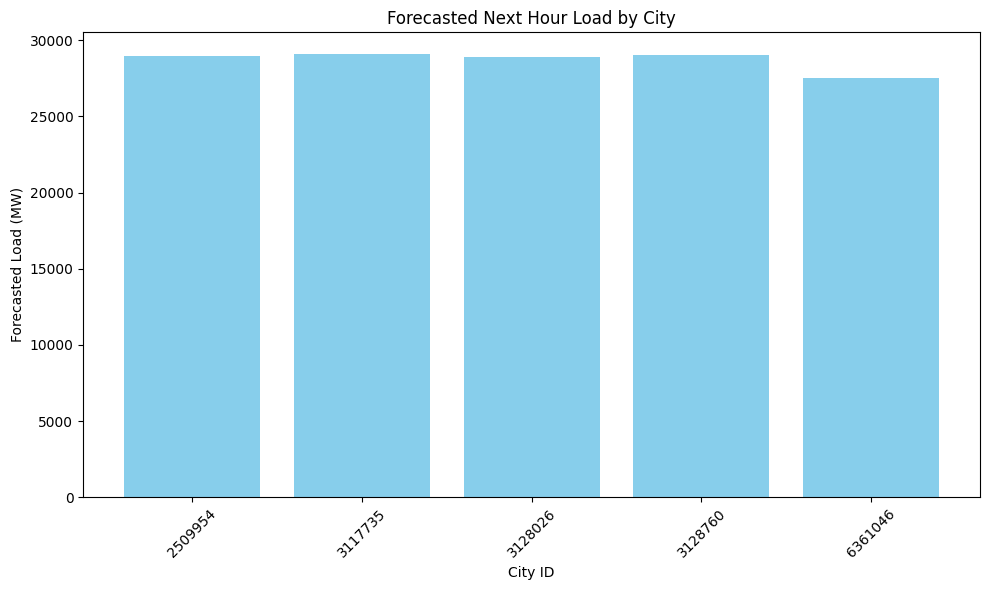

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(forecast_df['city_id'].astype(str), forecast_df['forecasted_next_hour_load'], color='skyblue')
plt.title("Forecasted Next Hour Load by City")
plt.xlabel("City ID")
plt.ylabel("Forecasted Load (MW)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [36]:
forecast_df.to_csv("citywise_forecast_load.csv", index=False)


In [38]:
# app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

st.title("Renewable Energy Forecasting - City-wise Load Prediction")

df = pd.read_csv("citywise_forecast_load.csv")

selected_city = st.selectbox("Select a City ID", df['city_id'])
forecast = df[df['city_id'] == selected_city]['forecasted_next_hour_load'].values[0]

st.metric("Forecasted Load (Next Hour)", f"{forecast:.2f} MW")

st.bar_chart(df.set_index("city_id"))


2025-06-19 19:35:39.973 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 19:35:39.975 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 19:35:39.976 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 19:35:39.981 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 19:35:39.982 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 19:35:39.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 19:35:39.985 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 19:35:39.987 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()